## Digikala Dataset (Persian Sentiment Analysis)
Download form kaggle with this usrl:
https://www.kaggle.com/datasets/soheiltehranipour/digikala-comments-persian-sentiment-analysis

In [ ]:
# pip install kagglehub
#!pip install hazm

In [ ]:
# import kagglehub
# path = kagglehub.dataset_download("soheiltehranipour/digikala-comments-persian-sentiment-analysis")
# print("Path to dataset files:", path)

# 1. Add library we need

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
from hazm import Normalizer, word_tokenize, stopwords_list

# 2. Data loading

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv("data.csv")
def map_sentiment(score):
    if score >= 50:
        return "positive"
    elif score <= 50:
        return "negative"

df['Sentiment'] = df.apply(lambda row: map_sentiment(row['Score']), axis=1)

normalizer = Normalizer()
def preprocess_text(text):
    if isinstance(text, str):
        text = normalizer.normalize(text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text)
        stops = set(stopwords_list())
        tokens = [token for token in tokens if token not in stops]
        return tokens
    return []

df['tokens'] = df['Text'].apply(preprocess_text)
df['sentiment'] = df['Sentiment'].map({'positive': 1, 'negative': 0})
df = df.drop(["Text","Score","Suggestion","Sentiment"],axis='columns')

# 3. Creating Vocabulary

In [24]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab = set(all_tokens)
vocab_size = len(vocab) + 2
word_to_idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

MAX_LENGTH = 100

def tokens_to_indices(tokens, max_length=MAX_LENGTH):
    indices = [word_to_idx.get(token, 1) for token in tokens[:max_length]]

    if len(indices) < max_length:
        indices += [0] * (max_length - len(indices))
    return indices

df['indices'] = df['tokens'].apply(tokens_to_indices)

# 4. Train/Validation Split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    list(df['indices']),
    list(df['sentiment']),
    test_size=0.2,
    random_state=42
)

# 5. Create Custom Dataset

In [26]:
class DigiKalaDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_tensor = torch.tensor(self.texts[idx], dtype=torch.long)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return text_tensor, label_tensor

train_dataset = DigiKalaDataset(X_train, y_train)
val_dataset = DigiKalaDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 6. Define the Model

In [27]:
# class SentimentClassifier(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1):
#         super(SentimentClassifier, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#         self.lstm = nn.LSTM(embedding_dim,
#                           hidden_dim,
#                           num_layers=n_layers,
#                           bidirectional=True,
#                           batch_first=True)

#         self.fc = nn.Linear(hidden_dim * 2, output_dim)

#     def forward(self, text):
#         embedded = self.embedding(text)
#         output, (hidden, cell) = self.lstm(embedded)
#         return self.fc(output)

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=True,
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# 7. Initialize the model

In [28]:
embedding_dim = 300
hidden_dim = 256
output_dim = 1
n_layers = 2
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)
model = model.to(device)

# 8. Define loss function and optimizer

In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 9. Training Function

In [32]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        text, labels = batch
        text = text.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float()
        acc = correct.sum() / len(correct)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# 10. Evaluation Function

In [33]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            labels = labels.float().to(device)

            predictions = model(text).squeeze(1)

            loss = criterion(predictions, labels)

            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            acc = correct.sum() / len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# 11. Training Loop

In [34]:
n_epochs = 10
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best-model.pt')

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}%')

Starting training...
Epoch: 1
	Train Loss: 0.371 | Train Acc: 89.06%
	Val. Loss: 0.310 | Val. Acc: 89.81%
Epoch: 2
	Train Loss: 0.260 | Train Acc: 90.19%
	Val. Loss: 0.348 | Val. Acc: 87.97%
Epoch: 3
	Train Loss: 0.148 | Train Acc: 95.20%
	Val. Loss: 0.367 | Val. Acc: 87.54%
Epoch: 4
	Train Loss: 0.078 | Train Acc: 97.40%
	Val. Loss: 0.516 | Val. Acc: 84.86%
Epoch: 5
	Train Loss: 0.033 | Train Acc: 99.12%
	Val. Loss: 0.672 | Val. Acc: 87.97%
Epoch: 6
	Train Loss: 0.030 | Train Acc: 99.16%
	Val. Loss: 0.639 | Val. Acc: 86.84%
Epoch: 7
	Train Loss: 0.021 | Train Acc: 99.42%
	Val. Loss: 0.745 | Val. Acc: 86.69%
Epoch: 8
	Train Loss: 0.009 | Train Acc: 99.70%
	Val. Loss: 0.756 | Val. Acc: 85.99%
Epoch: 9
	Train Loss: 0.010 | Train Acc: 99.76%
	Val. Loss: 0.844 | Val. Acc: 87.26%
Epoch: 10
	Train Loss: 0.007 | Train Acc: 99.89%
	Val. Loss: 0.839 | Val. Acc: 87.54%


# 12. Test on Sample Comments

In [40]:
def predict_sentiment(model, text, max_length=MAX_LENGTH):
    model.eval()
    preprocessed_text = preprocess_text(text)
    indices = tokens_to_indices(preprocessed_text, max_length)
    tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    prediction = torch.sigmoid(model(tensor)).item()

    return prediction

model.load_state_dict(torch.load('best-model.pt'))

sample_comments = [
    "من از خرید راضی هستم",
     "خیلی بدیهه",
]

print("\nSample Predictions:")
for comment in sample_comments:
    sentiment = predict_sentiment(model, comment)
    print(f"Comment: {comment}")
    print(f"Sentiment: {'Positive' if sentiment > 0.9 else 'Negative'})")



Sample Predictions:
Comment: من از خرید راضی هستم
Sentiment: Positive)
Comment: خیلی بدیهه
Sentiment: Negative)


# 13. Calculate Evaluation Metrics

In [ ]:
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            text, labels = batch
            text = text.to(device)

            predictions = model(text).squeeze(1)
            predicted_classes = torch.round(torch.sigmoid(predictions))

            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    return acc, precision, recall, f1

val_acc, val_precision, val_recall, val_f1 = calculate_metrics(model, val_loader)

print("\nFinal Evaluation Metrics on Validation Set:")
print(f"Accuracy: {val_acc*100:.2f}%")
print(f"Precision: {val_precision:.3f}")
print(f"Recall: {val_recall:.3f}")
print(f"F1 Score: {val_f1:.3f}")

# 👇👇 bounous 👇👇

# Classic Solution ( TFIDF )

### 1. **Install with pip library we need**

In [ ]:
#pip install kagglehub
#!pip install hazm

### 2. **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import kagglehub
from hazm import * # Persian Tokenizer

### **Downlodad Dataset from kagglehub**

In [ ]:
# path = kagglehub.dataset_download("soheiltehranipour/digikala-comments-persian-sentiment-analysis")
# print("Path to dataset files:", path)

### 3. **Read Data**

In [ ]:
df = pd.read_csv("data.csv")
df.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


### 4. **Preprocess**

1 indicates suggesting others to buy 2 means otherwise 3 illustrate a neutral opinion about the product

In [ ]:
print(df.isna().sum())
print(df.describe())
percentages = df["Suggestion"].value_counts(normalize=True).to_dict()
fig = px.pie(values=percentages,
             names=list(percentages.keys()),
             title='percent of 1,2,3 in data')
fig.show()

Text          0
Score         0
Suggestion    0
dtype: int64
             Score  Suggestion
count  3261.000000  3261.00000
mean     74.719411     1.41061
std      21.514015     0.72408
min       0.000000     1.00000
25%      60.000000     1.00000
50%      80.000000     1.00000
75%      92.000000     2.00000
max     100.000000     3.00000


In [ ]:
# def change_score(x):
#     if x >= 80: return 0 #Perfect
#     elif x >= 60: return 1 #Good
#     elif x >= 40: return 2 #Alright
#     elif x >= 20: return 3 #Bad
#     else : return 4 #Terrible
# df["Score"] = df["Score"].apply(lambda x : change_score(x))
def change_score(x):
    if x > 50 :
      return 1
    else :
      return 0
df["label"] = df["Score"].apply(lambda x : change_score(x))

<Axes: ylabel='count'>

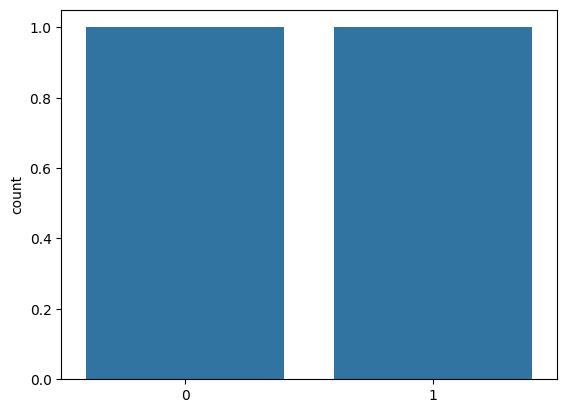

In [ ]:
df = df.drop(["Score","Suggestion"],axis=1)
percentages = df["label"].value_counts(normalize=True).to_dict()
sns.countplot(percentages)

### 5. **split train and test**

In [ ]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(df["Text"],df["label"], test_size=0.2,shuffle=True)

### 6. **Model**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

tfidf = TfidfVectorizer().fit(x_train)
txt_model = XGBClassifier()
txt_model.fit(tfidf.transform(x_train), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 7. **Training and Evaluating the Model**

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(y_test,txt_model.predict(tfidf.transform(x_test))))

              precision    recall  f1-score   support

           0       0.57      0.13      0.22        60
           1       0.92      0.99      0.95       593

    accuracy                           0.91       653
   macro avg       0.75      0.56      0.58       653
weighted avg       0.89      0.91      0.89       653



# Bert and family Solution

In [ ]:
df.rename(columns={'comment': 'text'}, inplace=True)
df.reset_index(drop=True,inplace=True)

## Albert

### 1. **Install Library we need**

In [ ]:
# !pip install datasets
# !pip install --upgrade torch transformers datasets
# !pip show torch transformers datasets
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Pretrained from ALBERT-Persian (HooshvareLab)
link :  https://huggingface.co/HooshvareLab/albert-fa-zwnj-base-v2

### 2. **Use Library**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

### 3. **Check That we are in GPU or not**

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["WANDB_DISABLED"] = "true"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 4. **Use model that Pretrained**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/albert-fa-zwnj-base-v2")
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    "HooshvareLab/albert-fa-zwnj-base-v2",
    num_labels=num_labels
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/857k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/44.9M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/albert-fa-zwnj-base-v2 and are newly initialized: ['albert.pooler.bias', 'albert.pooler.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.**Process and format dataset**

In [ ]:
df.columns = ['textlabel', 'label']

#test_data = df[2750:3261]
#train_data = df[:2750]
train_data, test_data = train_test_split(
    dataset, test_size=0.2, shuffle=True, random_state=42
)

train_data = train_data.to_dict('records')
test_data = test_data.to_dict('records')

def preprocess_data(examples):
    """Tokenize and prepare the texts"""
    return tokenizer(
        examples['textlabel'],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data)
})
tokenized_dataset = dataset.map(preprocess_data, batched=True)

tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/2750 [00:00<?, ? examples/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

### 6. **Train and evalute**

In [ ]:
def compute_metrics(eval_pred):
    """Calculate metrics for evaluation"""
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1).numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='binary',
        zero_division=0
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": float(acc),
        "f1": float(f1),
        "precision": float(precision),
        "recall": float(recall)
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    no_cuda=not torch.cuda.is_available()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Starting training...")
trainer.train()
print("Training completed successfully!")

results = trainer.evaluate()
print("\nEvaluation Results:", results)


print("\nSaving model...")
trainer.save_model("./final_model")
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-f3f89acb1cdf>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.285417,0.906067,0.950617,0.905882,1.000000
2,No log,0.225280,0.913894,0.954262,0.918000,0.993506
3,0.266800,0.213674,0.933464,0.964059,0.942149,0.987013


Training completed successfully!



Evaluation Results: {'eval_loss': 0.21367447078227997, 'eval_accuracy': 0.9334637964774951, 'eval_f1': 0.9640591966173362, 'eval_precision': 0.9421487603305785, 'eval_recall': 0.987012987012987, 'eval_runtime': 4.2951, 'eval_samples_per_second': 118.972, 'eval_steps_per_second': 7.45, 'epoch': 3.0}

Saving model...
Model saved successfully!


## BERT (ParsBERT)

### 1. **Install Library we need**

In [ ]:
#!pip install datasets
#!pip install --upgrade torch transformers datasets
#!pip show torch transformers datasets
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Pretrained from ParsBERT (HooshvareLab)
link :  https://huggingface.co/HooshvareLab/bert-fa-base-uncased-sentiment-digikala

### 2. **Use Library**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### 3. **Check That we are in GPU or not**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 4. **Use model that Pretrained**

In [ ]:
model_name = "HooshvareLab/bert-fa-base-uncased-sentiment-digikala"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-digikala and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.Process and format dataset

In [ ]:
df.columns = ["textlabel", "label"]
df["label"] = df["label"].astype(int)
assert df["label"].isin([0, 1]).all(), "Labels must be 0 or 1 for binary classification."

#test_data = df[2750:3261]
#train_data = df[:2750]
train_data, test_data = train_test_split(
    dataset, test_size=0.2, shuffle=True, random_state=42
)



train_data = train_data.to_dict("records")
test_data = test_data.to_dict("records")

def preprocess_data(examples):
    return tokenizer(
        examples["textlabel"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data)
})

tokenized_dataset = dataset.map(preprocess_data, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/2750 [00:00<?, ? examples/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

### 6. **Train and evalute**

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate()
print("Evaluation Results:", results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.242431,0.919765,0.957068,0.926978,0.989177
2,0.286100,0.258141,0.931507,0.962726,0.947589,0.978355
3,0.150200,0.306831,0.941292,0.967880,0.957627,0.978355


Evaluation Results: {'eval_loss': 0.3068305552005768, 'eval_accuracy': 0.9412915851272016, 'eval_f1': 0.9678800856531049, 'eval_precision': 0.9576271186440678, 'eval_recall': 0.9783549783549783, 'eval_runtime': 3.8823, 'eval_samples_per_second': 131.622, 'eval_steps_per_second': 16.485, 'epoch': 3.0}
